# Dengue Outbreak Prediction

This notebook demonstrates dengue outbreak prediction using the **DrivenData** competition dataset.

## Dataset
- **Source**: [DrivenData - DengAI Competition](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)
- **Features**: Weather data, location info
- **Target**: Weekly dengue case counts

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

Libraries loaded successfully!


## 1. Data Loading

Load the DrivenData dengue dataset files:
- `dengue_features_train.csv` - Weather and environmental features
- `dengue_labels_train.csv` - Weekly case counts

In [3]:
# Load data from data/raw/dengue folder
DATA_PATH = "../data/raw/dengue"

try:
    features_df = pd.read_csv(f"{DATA_PATH}/dengue_features_train.csv")
    labels_df = pd.read_csv(f"{DATA_PATH}/dengue_labels_train.csv")
    print(f"Features shape: {features_df.shape}")
    print(f"Labels shape: {labels_df.shape}")
except FileNotFoundError as e:
    print("ERROR: Data files not found!")
    print(
        "Please download from: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/"
    )
    print(f"Place files in: {DATA_PATH}/")
    raise e

Features shape: (1456, 24)
Labels shape: (1456, 4)


In [4]:
# Merge features and labels
df = features_df.merge(labels_df, on=["city", "year", "weekofyear"])
print(f"Combined dataset shape: {df.shape}")
print(f"\nCities: {df['city'].unique()}")
print(f"Years: {df['year'].min()} - {df['year'].max()}")

df.head()

Combined dataset shape: (1456, 25)

Cities: ['sj' 'iq']
Years: 1990 - 2010


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [5]:
# Focus on San Juan (more data available)
city_name = "sj"  # 'sj' for San Juan, 'iq' for Iquitos
df = df[df["city"] == city_name].copy().reset_index(drop=True)
print(f"Using {city_name.upper()} data: {len(df)} weeks")

# Create date column
df["date"] = pd.to_datetime(df["week_start_date"])
df = df.sort_values("date").reset_index(drop=True)

print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Using SJ data: 936 weeks
Date range: 1990-04-30 00:00:00 to 2008-04-22 00:00:00


## 2. Exploratory Data Analysis

In [6]:
# Check columns
print("Available columns:")
print(df.columns.tolist())

Available columns:
['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm', 'total_cases', 'date']


In [7]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_df = pd.DataFrame({"Missing": missing, "Percent": missing_pct})
print("Missing values:")
print(missing_df[missing_df["Missing"] > 0].sort_values("Percent", ascending=False))

Missing values:
                                       Missing  Percent
ndvi_ne                                    191     20.4
ndvi_nw                                     49      5.2
ndvi_se                                     19      2.0
ndvi_sw                                     19      2.0
precipitation_amt_mm                         9      1.0
reanalysis_sat_precip_amt_mm                 9      1.0
reanalysis_avg_temp_k                        6      0.6
reanalysis_air_temp_k                        6      0.6
reanalysis_max_air_temp_k                    6      0.6
reanalysis_min_air_temp_k                    6      0.6
reanalysis_precip_amt_kg_per_m2              6      0.6
reanalysis_dew_point_temp_k                  6      0.6
reanalysis_relative_humidity_percent         6      0.6
reanalysis_specific_humidity_g_per_kg        6      0.6
reanalysis_tdtr_k                            6      0.6
station_avg_temp_c                           6      0.6
station_diur_temp_rng_c         

In [8]:
# Fill missing values with forward/backward fill
df = df.ffill().bfill()
print(f"Missing values after fill: {df.isnull().sum().sum()}")

Missing values after fill: 0


In [9]:
# Summary statistics for target
print("Dengue Cases Summary:")
print(df["total_cases"].describe())

Dengue Cases Summary:
count    936.000000
mean      34.180556
std       51.381372
min        0.000000
25%        9.000000
50%       19.000000
75%       37.000000
max      461.000000
Name: total_cases, dtype: float64


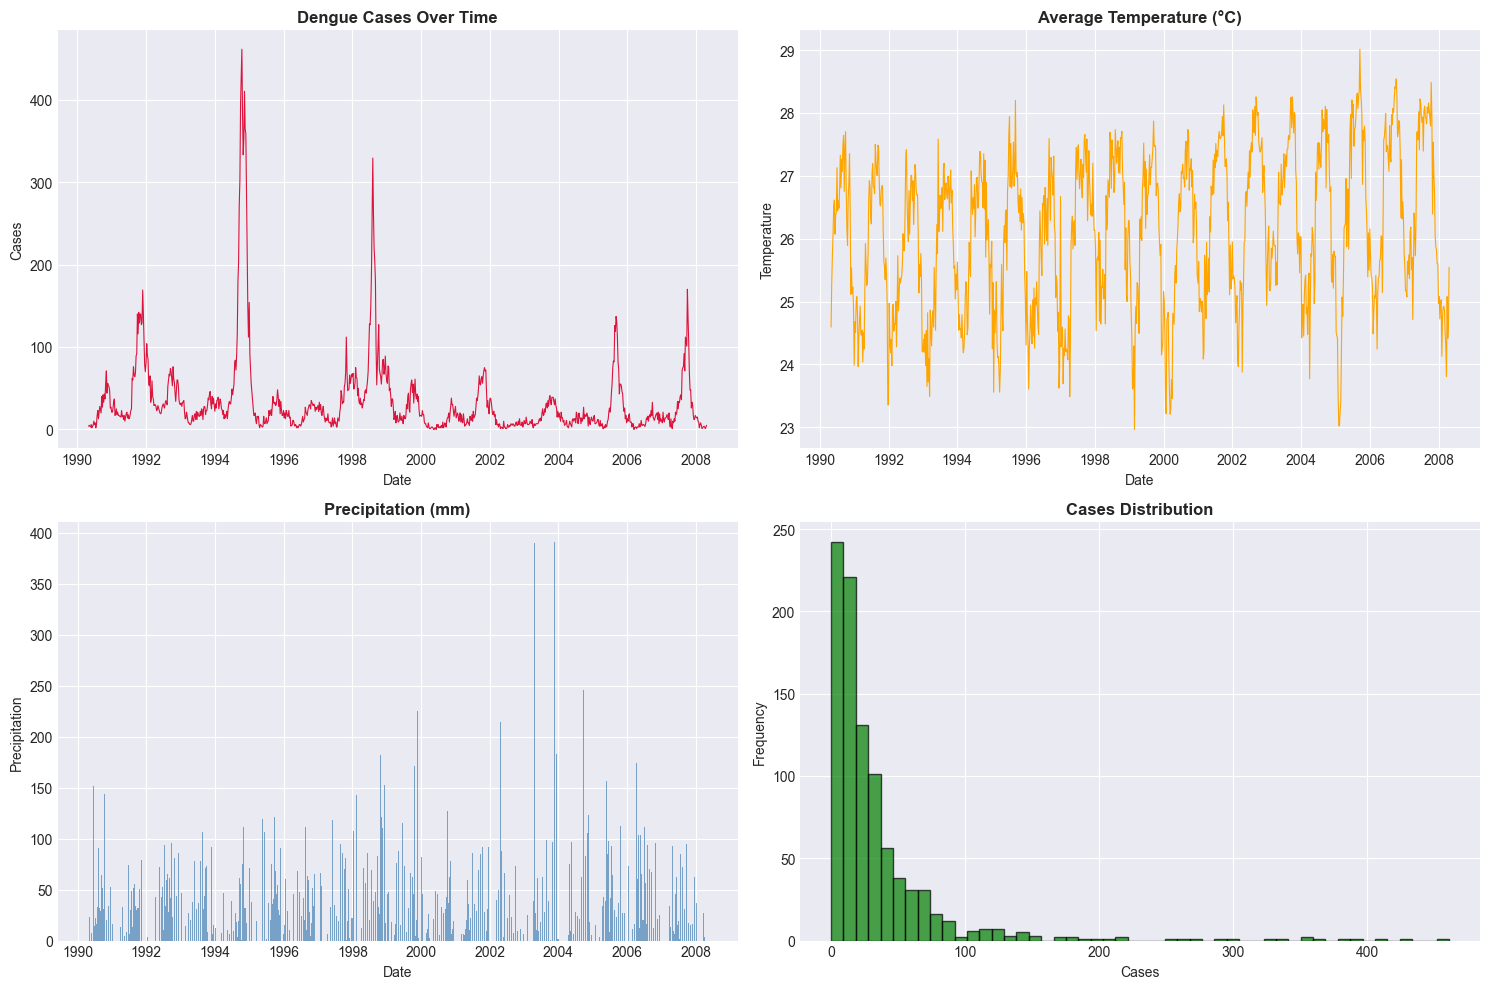

In [10]:
# Time series plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Cases over time
axes[0, 0].plot(df["date"], df["total_cases"], color="crimson", linewidth=0.8)
axes[0, 0].set_title("Dengue Cases Over Time", fontweight="bold")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Cases")

# Temperature
axes[0, 1].plot(
    df["date"], df["reanalysis_avg_temp_k"] - 273.15, color="orange", linewidth=0.8
)
axes[0, 1].set_title("Average Temperature (°C)", fontweight="bold")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Temperature")

# Precipitation
axes[1, 0].bar(
    df["date"], df["precipitation_amt_mm"], width=5, color="steelblue", alpha=0.7
)
axes[1, 0].set_title("Precipitation (mm)", fontweight="bold")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Precipitation")

# Cases distribution
axes[1, 1].hist(df["total_cases"], bins=50, color="green", alpha=0.7, edgecolor="black")
axes[1, 1].set_title("Cases Distribution", fontweight="bold")
axes[1, 1].set_xlabel("Cases")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## 3. Feature Engineering

Create lag features and rolling averages to capture temporal patterns.

In [11]:
# Rename columns for consistency
df = df.rename(
    columns={
        "reanalysis_avg_temp_k": "temp_avg",
        "reanalysis_min_air_temp_k": "temp_min",
        "reanalysis_max_air_temp_k": "temp_max",
        "precipitation_amt_mm": "precipitation_mm",
        "reanalysis_relative_humidity_percent": "humidity_percent",
    }
)

# Convert Kelvin to Celsius
for col in ["temp_avg", "temp_min", "temp_max"]:
    if col in df.columns:
        df[col] = df[col] - 273.15

print("Columns renamed and temperature converted to Celsius")

Columns renamed and temperature converted to Celsius


In [12]:
def create_features(data):
    """Create lag and rolling features"""
    df = data.copy()

    # Lag features for cases
    for lag in [1, 2, 3, 4]:
        df[f"cases_lag_{lag}"] = df["total_cases"].shift(lag)

    # Rolling features for weather
    for window in [2, 4]:
        df[f"temp_avg_roll_{window}w"] = df["temp_avg"].rolling(window).mean()
        df[f"precip_roll_{window}w"] = df["precipitation_mm"].rolling(window).mean()
        df[f"humidity_roll_{window}w"] = df["humidity_percent"].rolling(window).mean()

    # Seasonal encoding
    df["week_sin"] = np.sin(2 * np.pi * df["weekofyear"] / 52)
    df["week_cos"] = np.cos(2 * np.pi * df["weekofyear"] / 52)

    # Drop rows with NaN
    df = df.dropna()

    return df


df_feat = create_features(df)
print(f"Features created: {df.shape[1]} -> {df_feat.shape[1]}")
print(f"Samples: {len(df)} -> {len(df_feat)}")

Features created: 26 -> 38
Samples: 936 -> 932


## 4. Model Training

In [13]:
# Select features for training
exclude_cols = ["total_cases", "date", "week_start_date", "city", "year"]
feature_cols = [
    c
    for c in df_feat.columns
    if c not in exclude_cols
    and df_feat[c].dtype in ["float64", "int64", "float32", "int32"]
]

print(f"Features to use: {len(feature_cols)}")
print(feature_cols)

Features to use: 33
['weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_mm', 'reanalysis_air_temp_k', 'temp_avg', 'reanalysis_dew_point_temp_k', 'temp_max', 'temp_min', 'reanalysis_precip_amt_kg_per_m2', 'humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm', 'cases_lag_1', 'cases_lag_2', 'cases_lag_3', 'cases_lag_4', 'temp_avg_roll_2w', 'precip_roll_2w', 'humidity_roll_2w', 'temp_avg_roll_4w', 'precip_roll_4w', 'humidity_roll_4w', 'week_sin', 'week_cos']


In [14]:
# Prepare data
X = df_feat[feature_cols]
y = df_feat["total_cases"]

# Time-based split (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training: {len(X_train)} samples")
print(f"Testing: {len(X_test)} samples")

Training: 745 samples
Testing: 187 samples


In [15]:
# Train Random Forest
print("Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Done!")

# Train XGBoost
print("\nTraining XGBoost...")
xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print("Done!")

Training Random Forest...
Done!

Training XGBoost...
Done!


## 5. Model Evaluation

In [16]:
def evaluate(y_true, y_pred, name):
    """Calculate evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.3f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


rf_metrics = evaluate(y_test, rf_pred, "Random Forest")
print()
xgb_metrics = evaluate(y_test, xgb_pred, "XGBoost")

Random Forest:
  MAE:  6.85
  RMSE: 10.54
  R²:   0.886

XGBoost:
  MAE:  7.39
  RMSE: 11.86
  R²:   0.856


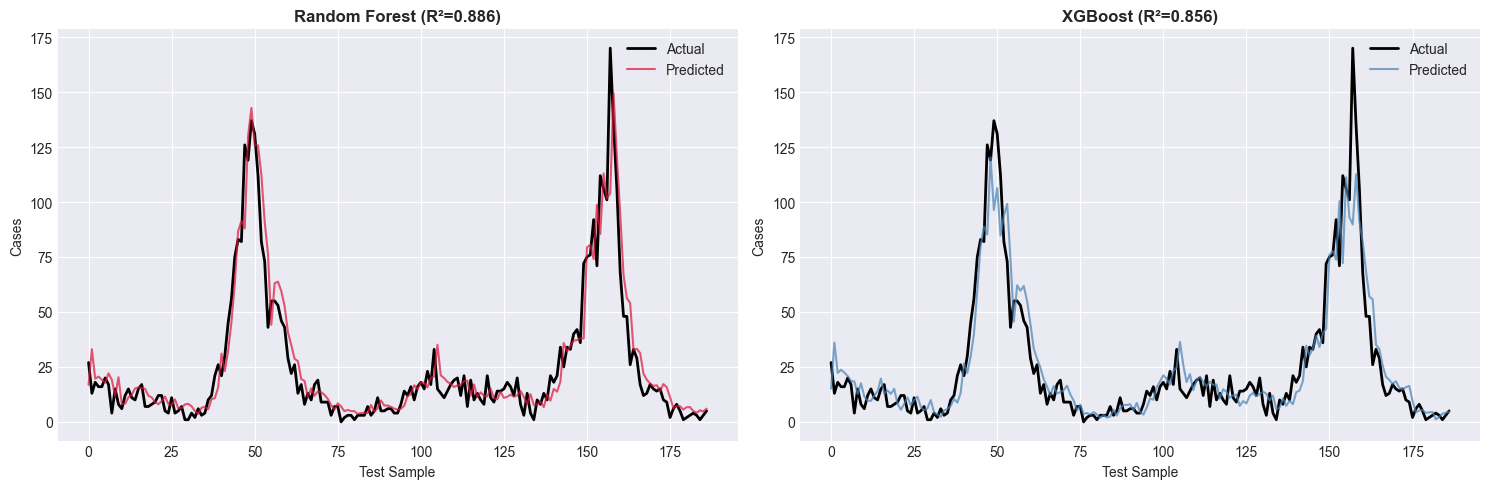

In [17]:
# Plot predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(y_test.values, label="Actual", color="black", linewidth=2)
axes[0].plot(rf_pred, label="Predicted", color="crimson", alpha=0.7)
axes[0].set_title(f"Random Forest (R²={rf_metrics['R2']:.3f})", fontweight="bold")
axes[0].legend()
axes[0].set_xlabel("Test Sample")
axes[0].set_ylabel("Cases")

axes[1].plot(y_test.values, label="Actual", color="black", linewidth=2)
axes[1].plot(xgb_pred, label="Predicted", color="steelblue", alpha=0.7)
axes[1].set_title(f"XGBoost (R²={xgb_metrics['R2']:.3f})", fontweight="bold")
axes[1].legend()
axes[1].set_xlabel("Test Sample")
axes[1].set_ylabel("Cases")

plt.tight_layout()
plt.show()

## 6. Feature Importance

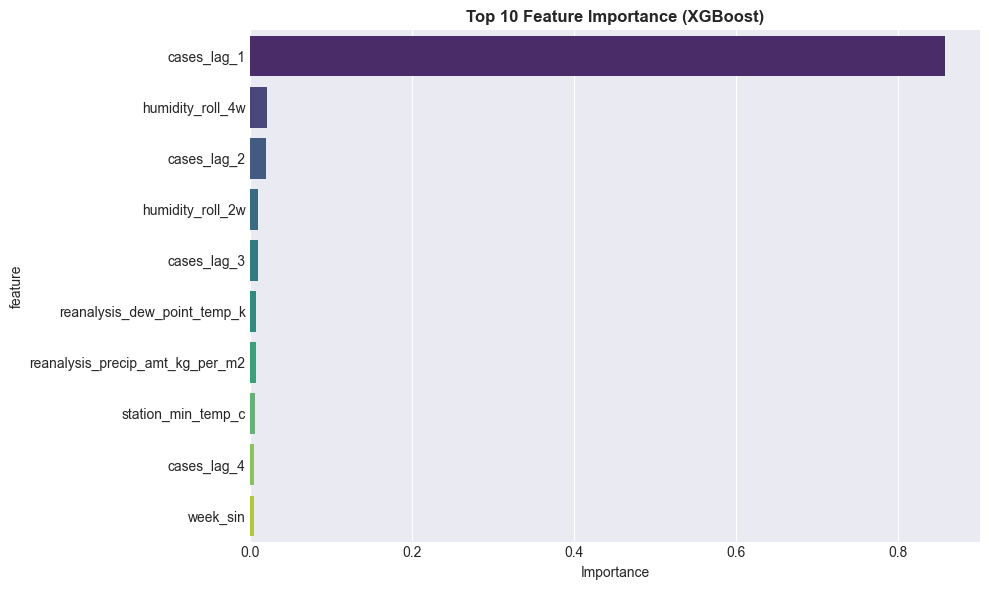

Top 5 features:
             feature  importance
21       cases_lag_1    0.858237
30  humidity_roll_4w    0.019956
22       cases_lag_2    0.018642
27  humidity_roll_2w    0.008967
23       cases_lag_3    0.008817


In [18]:
# Feature importance from XGBoost
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": xgb.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance.head(10), x="importance", y="feature", palette="viridis")
plt.title("Top 10 Feature Importance (XGBoost)", fontweight="bold")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

print("Top 5 features:")
print(importance.head())

## 7. Outbreak Detection

In [19]:
# Define outbreak threshold
outbreak_threshold = y_train.quantile(0.75)
print(f"Outbreak threshold (75th percentile): {outbreak_threshold:.1f} cases")

# Evaluate detection
actual_outbreak = y_test > outbreak_threshold
predicted_outbreak = xgb_pred > outbreak_threshold

tp = ((predicted_outbreak) & (actual_outbreak)).sum()
fp = ((predicted_outbreak) & (~actual_outbreak)).sum()
fn = ((~predicted_outbreak) & (actual_outbreak)).sum()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nOutbreak Detection:")
print(f"  Precision: {precision:.1%}")
print(f"  Recall: {recall:.1%}")

Outbreak threshold (75th percentile): 39.0 cases

Outbreak Detection:
  Precision: 91.4%
  Recall: 94.1%


## 8. Save Model

Save the trained model for use by the FastAPI backend.

In [20]:
import pickle

# Create models folder
os.makedirs("../models", exist_ok=True)

# Save XGBoost model
model_path = "../models/dengue_outbreak_predictor.pkl"

model_data = {
    "model": xgb,
    "feature_columns": feature_cols,
    "outbreak_threshold": outbreak_threshold,
    "metrics": xgb_metrics,
    "data_source": "DrivenData (San Juan)",
}

with open(model_path, "wb") as f:
    pickle.dump(model_data, f)

print(f"Model saved to: {model_path}")
print(f"Features: {len(feature_cols)}")
print(f"R² Score: {xgb_metrics['R2']:.3f}")

Model saved to: ../models/dengue_outbreak_predictor.pkl
Features: 33
R² Score: 0.856
